<a href="https://colab.research.google.com/github/developer-john67/Gaming_app/blob/main/working_with_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jokamau
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.50GB/s]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder
import os


In [ ]:
train_df= pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df= pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')

data_df= pd.concat([train_df, val_df], ignore_index= True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]


In [ ]:
train_df.shape

(1034, 2)

In [ ]:
data_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [ ]:
train_df.head()

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [ ]:
val_df.shape

(133, 2)

In [ ]:
train_df['category'].unique()

array([0, 1, 2])

In [ ]:
train_df['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [ ]:
transform= transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
train= data_df.sample(frac= 0.7, random_state= 42)
test= data_df.drop(train.index)

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, transform= None):
    self.dataframe= dataframe
    self.transform= transform
    self.labels= torch.tensor(dataframe['category']).to(device)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    image_path= self.dataframe.iloc[idx, 0]
    labels= self.labels[idx]
    image= Image.open(image_path).convert('RGB')

    if self.transform:
      image= (self.transform(image)/ 255).to(device)

    return image, labels

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train_dataset= dataset(dataframe= train, transform= transform)
test_dataset= dataset(dataframe= test, transform= transform)

In [ ]:
LR= 1e-3
BATCH_SIZE= 64
EPOCHS= 10


In [ ]:
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

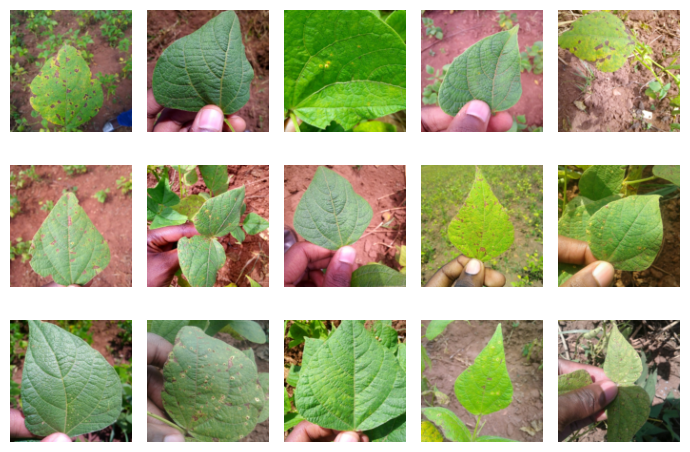

In [ ]:
num_rows= 3
num_cols= 5

f, ax= plt.subplots(num_rows, num_cols, figsize= (7, 5))
for row in range(num_rows):
  for col in range(num_cols):
      image= train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
      ax[row, col].imshow((image*255).squeeze().permute(1,2,0))
      ax[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision import models
googlenet_model= models.googlenet(weights= "DEFAULT")
for param in googlenet_model.parameters():
  param.requires_grad= True

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 224MB/s]


In [ ]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [ ]:
optimizer= optim.Adam(googlenet_model.parameters(), lr= LR)
criterion= nn.CrossEntropyLoss()

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  for input, label in train_loader: # Changed to train_loader for batched input
    input, label= input.to(device), label.to(device)
    googlenet_model.train()
    optimizer.zero_grad()

    output= googlenet_model(input)
    loss= criterion(output, label)
    loss.backward()
    optimizer.step()

    total_loss_train += loss.item() * input.size(0) # Accumulate loss correctly for the batch
    acc= output.argmax(dim= 1).eq(label).sum().item()
    total_acc_train += acc

  # Calculate and append metrics once per epoch
  avg_epoch_loss = total_loss_train / len(train_dataset)
  avg_epoch_acc = (total_acc_train / len(train_dataset)) * 100

  total_loss_train_plot.append(round(avg_epoch_loss, 4))
  total_acc_train_plot.append(round(avg_epoch_acc, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(avg_epoch_loss, 4)} Train Accuracy {round(avg_epoch_acc, 4)}%')
  print()

Epoch 1/10, Train Loss: 0.7576 Train Accuracy 66.9523%

Epoch 2/10, Train Loss: 0.446 Train Accuracy 83.3537%

Epoch 3/10, Train Loss: 0.3323 Train Accuracy 87.7601%

Epoch 4/10, Train Loss: 0.2126 Train Accuracy 92.4113%

Epoch 5/10, Train Loss: 0.1269 Train Accuracy 95.9608%

Epoch 6/10, Train Loss: 0.132 Train Accuracy 95.3488%

Epoch 7/10, Train Loss: 0.1149 Train Accuracy 95.8384%

Epoch 8/10, Train Loss: 0.1098 Train Accuracy 95.716%

Epoch 9/10, Train Loss: 0.1071 Train Accuracy 95.5936%

Epoch 10/10, Train Loss: 0.0923 Train Accuracy 96.94%



In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):
    googlenet_model.eval()
    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 32.57%


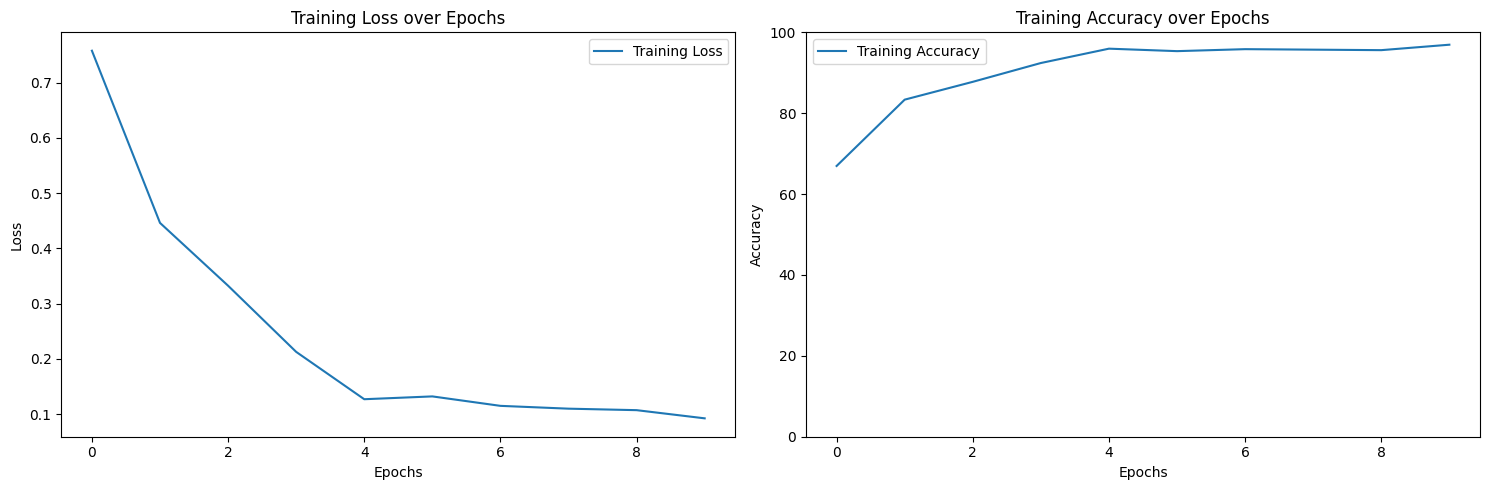

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()